<a href="https://colab.research.google.com/github/katherymbr/Dim_fractalMontecarlo_Sierpinskipinsk/blob/main/Sin_Metodologia_3_Dim_fractal_Montecarlo_MIAS_271.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  DIMENSION DE HAUSDORFF O FRACTAL, USANDO EL M√âTODO MONTECARLO+ MAMOGRAF√çAS con _MIAS_271

# IMPLEMENTACI√ìN DEL M√âTODO EN MAMOGRAFIAS

*  DIMENSION DE HAUSDORFF O FRACTAL

Despues de realizar la Calibraci√≥n del metodo de dimensi√≥n fractal integrado con montecarlo, con el triangulo de selspinski, se procedio a calcular la dimension fractal bajo este metodo en mamografias con microcalcificaciones

*  M√©todo  montecarlo

El m√©todo de Montecarlo se integrar√° al c√°lculo de la dimensi√≥n fractal. Para ello, se generar√°n puntos aleatorios dentro del viewport que cumplan con la distribuci√≥n de Montecarlo, es decir, puntos que satisfagan
ùë•
2
+
ùë¶
2
‚â§
ùëü
2
 , donde
ùëü
2
=
(
ùëô
/
2
)
2

  y
ùëô
l es el lado del viewport, el cual debe ser cuadrado. Posteriormente, en esos puntos que cumplen la distribuci√≥n de Montecarlo, se ubica la imagen dentro del viewport y se cuenta el n√∫mero de p√≠xeles para 2 divisiones del Box Counting, 4 divisiones, 16 divisiones, y as√≠ sucesivamente. Este proceso se repite para cada posici√≥n generada por Montecarlo. Finalmente, se grafica la relaci√≥n
log
‚Å°
(
1
/
boxes
)
vs.
log(N), donde la pendiente de la gr√°fica representa la dimensi√≥n fractal.


Nota: Es crucial tener precauci√≥n con los puntos de Montecarlo al posicionar la imagen dentro del viewport seg√∫n la condici√≥n establecida. Se debe evitar o RESTRINGIR que los puntos queden en las fronteras del c√≠rculo de Montecarlo, ya que esto puede resultar en que la imagen se divida entre el interior y el exterior del c√≠rculo. Este fen√≥meno es evidente en la simulaci√≥n.



```
# Proyecto 3 - Fractales
```

Autores: Katherym Bambague Ru√≠z, Ronny Guevara

*   Importo liberias

In [17]:
import imageio as io
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters, data, exposure
import math
import random
import pandas  as pd
import numpy as np
from scipy.stats import linregress


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# FUNCIONES

# F - VISUALIZACION Y TAMA√ëO

In [16]:
# LEER IMAGEN
def leer_imagen(rute):
  imagen= io.imread(rute)
  return(imagen)

ruta='/content/drive/MyDrive/'

In [3]:
# TAMA√ëO DE LA IMAGEN Y EL PIXEL M√ÅXIMO Y M√çNIMO

def tama√±o_imagen(imagen):
    print('dimensiones de la imagen', imagen.shape)
    print ('valor MINIMO del pixel:',imagen.min())
    print('valor M√ÅXIMO del pixel:', imagen.max())

In [4]:
# GRAFICAR 2 IMAGENES HORIZONTALES CON T√çTULO

import matplotlib.pyplot as plt

def graficar_dosimagenes_horizontaltitulo(imagen_oscura, imagen_brillante, titulo1, titulo2, tama√±o=100):
    fig, ax = plt.subplots(1, 2, dpi=tama√±o)

    # Primer subgr√°fico
    ax[0].imshow(imagen_oscura, cmap='gray')
    ax[0].set_axis_off()
    ax[0].set_title(str(titulo1))  # Utilizar set_title para establecer el t√≠tulo

    # Segundo subgr√°fico
    ax[1].imshow(imagen_brillante, cmap='gray')
    ax[1].set_axis_off()
    ax[1].set_title(str(titulo2))  # Utilizar set_title para establecer el t√≠tulo

    plt.show()

# 1.  F - DESCOMPONER IMAGEN EN SUS CANALES R,G,B

In [5]:
# FUNCI√ìN PARA DESCOMPONER LA IMAGEN EN SUS CANALES R,G,B

def image_to_rgb(imagen):

  r = imagen[:,:,0]/255.0
  g = imagen[:,:,1]/255.0
  b = imagen[:,:,2]/255.0

  return r, g, b


# 2. F - PASAR DE RGB A YIQ

In [6]:
# FUNCI√ìN PARA PASAR DE RGB A YIQ

def rgb_yiq (r1,g1,b1):

  y= 0.299*r1  +0.587*g1   +0.11*b1
  i= 0.596*r1  -0.274*g1   -0.322*b1
  q= 0.211*r1  -0.523*g1   +0.312*b1

  return(y,i,q)


Funciones para img Fito

In [7]:
# *********************
# FUNCION OARA MARCAR IMG FITO
import cv2

def area_afectada_cuatro(img5, x1, y1, x2, y2, x3, y3, x4, y4):
    img5_copy = np.copy(img5)

    # Color en formato RGB (255, 87, 51) que corresponde a #FF5733
    color = (255, 87, 51)

    # Dibuja las l√≠neas del rect√°ngulo en el color especificado
    cv2.line(img5_copy, (x1, y1), (x2, y2), color, 5)
    cv2.line(img5_copy, (x2, y2), (x3, y3), color, 5)
    cv2.line(img5_copy, (x3, y3), (x4, y4), color, 5)
    cv2.line(img5_copy, (x4, y4), (x1, y1), color, 5)

    return img5_copy


In [8]:
# funcion para CORTAR UNA IMAGEN mamaria en la imagen fito

def imagen_recorte_fito(imagen,y1,y4,x1,x2):
    imagen_recorte= imagen[y1:y4 , x1:x2]
    #graficar_imagen(imagen_recorte , 'imagen recortada', tama√±o=90)
    return(imagen_recorte)

FUNCIONES PARA MIAS

In [9]:
#funcion para dibujar area afectada de Mias
# En esta funci√≥n el origen de cordenadas est√° en la esquina inferior izquierda

def dibujar_area_afectada_mias(img, x, y, r):

    # Origen de la imagen en (x=0, y=maximo_y)
    y = img.shape[0] - y
    img_copy = np.copy(img)
    cv2.line(img_copy,(x-r,y-r),(x+r,y-r),(255,0,0),4)
    cv2.line(img_copy,(x-r,y+r),(x+r,y+r),(255,0,0),4)
    cv2.line(img_copy,(x-r,y-r),(x-r,y+r),(255,0,0),4)
    cv2.line(img_copy,(x+r,y-r),(x+r,y+r),(255,0,0),4)
    return img_copy

In [10]:
#funcion para recortar imagenes de Mias
# En esta funci√≥n el origen de cordenadas est√° en la esquina inferior izquierda

def recorte_area_afectada_mias(img, x, y, r):
  img_copy = np.copy(img)
  y = img.shape[0] - y
  img_recorte = img_copy[y-r:y+r, x-r:x+r]
  return img_recorte

#  3. F - UMBRAL OTSU - SIMPLE

In [11]:
# FUNCI√ìN PARA CALCULAR EL UMBRAL DE OTSU

def Otsu(imagen):

  umbral_otsu= filters.threshold_otsu(imagen)
  # Calcular el histograma de la imagen
  hist, bins_center = exposure.histogram(imagen)

  # Graficar el histograma
  plt.figure(figsize=(10, 5))
  plt.subplot(121)
  plt.bar(bins_center, hist, width=0.5, color='gray')
  plt.title('Histograma de la imagen')
  plt.xlabel('Intensidad de p√≠xel')
  plt.ylabel('Frecuencia')

  # Graficar el umbral de Otsu
  plt.axvline(umbral_otsu, color='r', linestyle='--', linewidth=2, label='Umbral de Otsu')
  plt.legend()

  # Mostrar la imagen original y aplicar el umbral de Otsu
  plt.subplot(122)
  plt.imshow(imagen, cmap='gray')
  plt.title('Imagen con umbral de Otsu')
  plt.axhline(umbral_otsu, color='r',linestyle='--', linewidth=0.01)
  plt.axis('off')
  plt.show()

  return umbral_otsu


# 4. F -  BINARIZAR UNA IM√ÅGEN

In [12]:
# FUNCI√ìN PARA BINARIZAR UNA IMAG√âN

def binarizacion(img_norm, umbral):

  im_binary1 = np.copy(img_norm)

  mask_1 = im_binary1 >=  umbral  # umbral_otsu
  mask_2 = im_binary1 <  umbral   # umbral_otsu

  im_binary1[mask_1] = 1 # pixeles mayores, igualeses a umbral_otsu: toman tomar el valor de 1
  im_binary1[mask_2] = 0 # pixeles menores a umbral_otsu: toman tomar el valor de 0

  print(im_binary1.shape)
  print("pixel minimo:",im_binary1.max())
  print("pixel m√°ximo:",im_binary1.min())

  return im_binary1


# 5. F - VIEWPORT CUADRADO Y PUNTOS MONTECARLO

In [13]:
# FUNCI√ìN QUE GENERA EL VIEWPORT CUADRADO A PARTIR DE UNA IMAGEN DE ENTRADA Y UN FACTOR BETA

def viewport_cuadrado(img, beta):
    "beta es el Factor de incremento del viewport con respecto a las dimensiones de la imagen"
    # Definici√≥n del √°rea del viewport
    viewport_y, viewport_x = img.shape
    print("--------------------------------------")
    print("Dimensiones de la imagen de entrada a la funci√≥n - viewport cuadrado-:", img.shape)
    # Ajustar las dimensiones para que el viewport sea cuadrado
    max_dimension = max(viewport_y, viewport_x)
    print("--------------------------------------")
    print("Se tomar√° el lado mas grande de la imagen de entrada, para formar el cuadrado:", max_dimension)
    # Ajustar las dimensiones dado el factor beta
    max_dimension = int(max_dimension * beta)
    print("--------------------------------------")
    print("El factor de incremento de la iamgen sera un factor Beta: ", beta)
    # Crear un viewport cuadrado
    viewport = np.zeros((max_dimension,  max_dimension))
    print("--------------------------------------")
    print("Dimensiones del viewport: {}".format(viewport.shape))
    print("--------------------------------------")
    return  viewport

# FUNCI√ìN PARA DIBUJAR UN CIRCULO ENCIMA DE CUALQUIER IMAGEN DE ENTRADA "cuadrada". Donde el radio del circulo es la mitad del larfo de la imagen

def generar_circulo(img):
    # Obtiene las dimensiones de la imagen
    alto_y, ancho_x = img.shape[:2]
    # Calcula el centro de la imagen
    centro_x = ancho_x / 2
    centro_y = alto_y / 2
    print("++++++++++++++++++++++++++++++++++++++")
    print("El radio del circulo dibujado es:", centro_x)
    print("++++++++++++++++++++++++++++++++++++++")
    # genera el c√≠rculo dado el centro
    circulo = plt.Circle((centro_x, centro_y), ancho_x / 2, color='blue', fill=False)
    return circulo

# Funci√≥n para verificar si un punto cumple con la condici√≥n de MONTECARLO
def verificar_condicion(x, y, ancho_x):
    return x ** 2 + y ** 2 <= (ancho_x / 2) ** 2

# FUNCION PARA GENERAR PUNTOS MONTECARLO
def generar_puntos_montecarlo(img, num_puntos):
    print("El total de puntos aleatorios a evaluar es: ", num_puntos)
    print(".....................................")
    puntos_cumplen_condicion = []
    alto_y, ancho_x = img.shape[:2]
    # Definir el n√∫mero de puntos a generar
    for i in range(num_puntos):
        # Generar coordenadas (x, y) dentro del rango especificado
        x = random.uniform(0, ancho_x)
        y = random.uniform(0, alto_y)

        # Verificar si el punto cumple con la condici√≥n
        if verificar_condicion(x - ancho_x / 2, y - alto_y / 2, ancho_x):
            puntos_cumplen_condicion.append((x, y))
    print("los puntos que cumplen la condici√≥n de montecarlo sin importar la frontera:",puntos_cumplen_condicion)
    return puntos_cumplen_condicion

#FUNCI√ìN PARA VERIFICAR SI LOS 4 PUNTOS DE LA IMAGEN QUE SE INDEXA CUMPLE CON LA CONDICION DE MONTECARLO
# Y NO SE SALEN DEL CIRCULO

def verificar_im_en_circulo(x, y, im, viewport):

    l_view = viewport.shape[0]
    y_im, x_im = im.shape
    x_real = x - l_view/2
    y_real = y - l_view/2
    x_val = None
    y_val = None

    # Verificar que la imagen no se sale del rango del circulo en ninguno de los cuadrantes
    if (verificar_condicion(y_real,        x_real,        l_view) and
        verificar_condicion(y_real + y_im, x_real,        l_view) and
        verificar_condicion(y_real + y_im, x_real + x_im, l_view) and
        verificar_condicion(y_real,        x_real + x_im, l_view)):
      x_val, y_val = x, y
    return x_val, y_val


# 6. F - BOX COUNTING

In [14]:
# **************************** Box counting ***********************************************

# Invoco la funci√≥n: def box_counting2(img, viewport, x_val, y_val)
# viewport debe ser cuadrado

def box_counting2(img, viewport, x_val, y_val):

    y_im, x_im = img.shape
    viewport[y_val:y_val+y_im, x_val:x_val+x_im] = img

    viewport_y, viewport_x = viewport.shape

    # Obtengo la dimensi√≥n m√≠nima del viewport (ahora cuadrado)
    min_axes = min(viewport.shape)

    # Obtener la mayor potencia de 2 que sea menor al valor de min_axes
    nbase = 2 ** np.floor(np.log(min_axes) / np.log(2))

    # Se obtiene el exponente
    n = int(np.log(nbase) / np.log(2))

    #se obtiene el tama√±o de los boxes
    # Se obtienen los boxes (media) en base 2^n  hasta 2^1
    boxes = 2 ** np.arange(1, n + 1, 1)[::-1]


    # Contar los pixeles en cada box para cada partici√≥n 2^n
    # Considerando el tama√±o de los boxes se cuentan los pixeles que hay en cada box, para cada partici√≥n 2^n
    counts = []
    for box in boxes:
        bc = np.add.reduceat(
            np.add.reduceat(viewport, np.arange(0, viewport_y, box), axis=0),
            np.arange(0, viewport_x, box), axis=1)
        # Se cuentan el n√∫mero de box cuya suma de pixels sea mayor a 0 y menor box^2
        counts.append(len(np.where((bc > 0) & (bc < box ** 2))[0]))

    log_inv_boxes_X = np.log(1 / boxes)
    log_counts_y = np.log(counts)
    #print(log_counts_y )


    return log_inv_boxes_X[::-1], log_counts_y[::-1]


EJECUCUI√ìN

dimensiones de la imagen (1024, 1024)
valor MINIMO del pixel: 0
valor M√ÅXIMO del pixel: 234


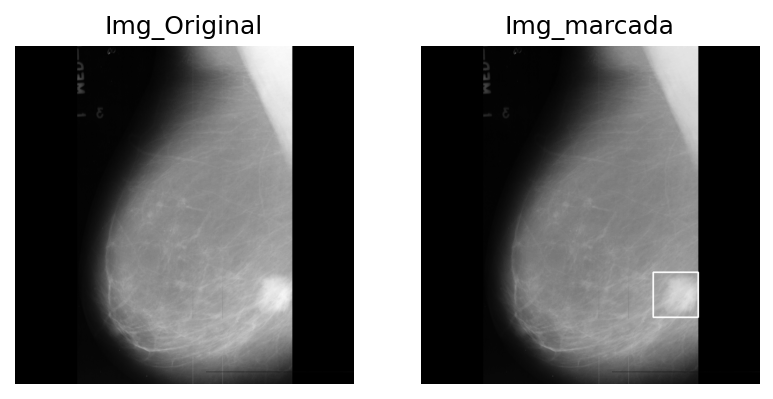

In [26]:
# Leo la imagen de la mamografia Original
#  MIAS 184
# SPIC Masas espiculadas


img_original =  leer_imagen (ruta+'mdb271.pgm')
tama√±o_imagen(img_original)

imagen_marcada = dibujar_area_afectada_mias(img_original ,769, 270 ,68) # dataset 784, 270 ,68

graficar_dosimagenes_horizontaltitulo(img_original, imagen_marcada,'Img_Original', 'Img_marcada', tama√±o=150)


tama√±o recorte de la img original: 
dimensiones de la imagen (136, 136)
valor MINIMO del pixel: 149
valor M√ÅXIMO del pixel: 228
tama√±o recorte de la img original despu√©s de NORMALIZAR: 
dimensiones de la imagen (136, 136)
valor MINIMO del pixel: 0.0
valor M√ÅXIMO del pixel: 1.0


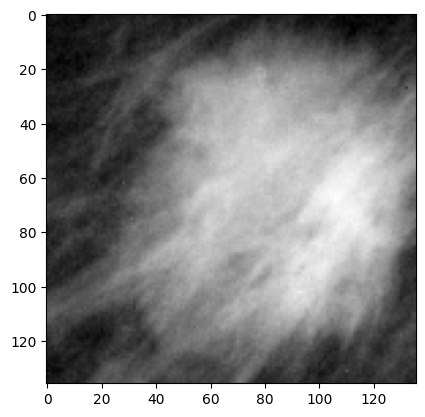

In [28]:

# Invoco una funcion para CORTAR UNA IMAGEN mamaria

imagen_recorte= recorte_area_afectada_mias(img_original,769, 270 ,68 )  # hago el recorte a la imagen original
print("tama√±o recorte de la img original: ")
tama√±o_imagen(imagen_recorte)

#Normalizo el recorte de la imagen original

imagen_recorte_norm=(imagen_recorte - imagen_recorte.min()) / (imagen_recorte.max() - imagen_recorte.min())  # normalizo la imagen y la llevo a la escala de 0 a 1
print("tama√±o recorte de la img original despu√©s de NORMALIZAR: ")
tama√±o_imagen(imagen_recorte_norm)
plt.imshow(imagen_recorte_norm, cmap='gray')

In [ ]:
# Descompongo la imagen en R, G, B

#r1,g1,b1= image_to_rgb(imagen1)


In [ ]:
# Paso la imagen del espacio RGB al espacio YIQ. Tomo las luminancias Y.
"""
y1,i1,q1= rgb_yiq (r1,g1,b1)
print(y1.shape)
print("pixel minimo:",y1.max())
print("pixel m√°ximo:",y1.min())
plt.imshow( y1, cmap='gray')
"""

'\ny1,i1,q1= rgb_yiq (r1,g1,b1)\nprint(y1.shape)\nprint("pixel minimo:",y1.max())\nprint("pixel m√°ximo:",y1.min())\nplt.imshow( y1, cmap=\'gray\')\n'

In [ ]:
# Normalizo la imagen que est√° en el espacio de luminancias (Y)
"""
#normalizo la imagen y la llevo a la escala de 0 a 1
imagen1_copy_norm=(y1 - y1.min()) / (y1.max() - y1.min())
print(imagen1_copy_norm.shape)
print("pixel minimo:",imagen1_copy_norm.max())
print("pixel m√°ximo:",imagen1_copy_norm.min())
"""

'\n#normalizo la imagen y la llevo a la escala de 0 a 1\nimagen1_copy_norm=(y1 - y1.min()) / (y1.max() - y1.min())\nprint(imagen1_copy_norm.shape)\nprint("pixel minimo:",imagen1_copy_norm.max())\nprint("pixel m√°ximo:",imagen1_copy_norm.min())\n'

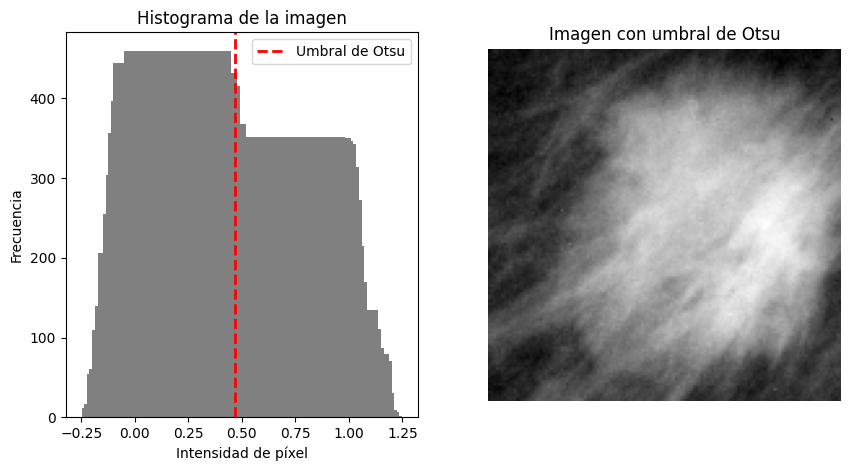

EL UMBRAL DE OTSU ES: 0.466796875


In [29]:
# Aplico la funci√≥n para encontrar el Umbral de Otsu  en imagenes normaizadas entre 0 y 1. Despu√©s grafico

umbral_otsu = Otsu(imagen_recorte_norm)
print("EL UMBRAL DE OTSU ES:",umbral_otsu)


BINARIZACI√ìN: Se binariza la imagen usando el umbral de Otsu obtenido anteriormente

(136, 136)
pixel minimo: 1.0
pixel m√°ximo: 0.0


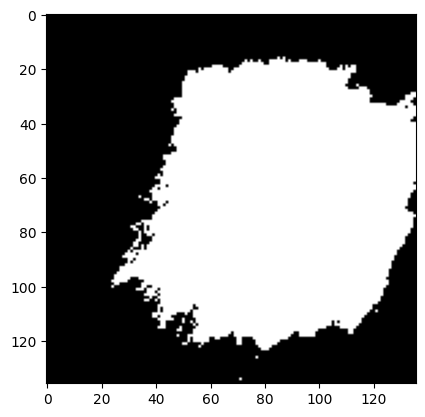

In [30]:
# Binarizo la imagen usando el umbral de OTSU y la funci√≥n para binarizar

img_binarizada= binarizacion(imagen_recorte_norm,  umbral_otsu)
plt.imshow(img_binarizada, cmap='gray')


## INVOCO LAS FUNCIONES PARA VIERPORT CUADRADO Y MONTECARLO

In [31]:
# Uso las funciones que estan en. 5.VIEWPORT CUADRADO Y PUNTOS MONTECARLO

# Invoco:  def viewport_cuadrado(img, beta):
view_cuadrado = viewport_cuadrado(img_binarizada, beta=5)

# Invoco: def generar_circulo(img):
circulo = generar_circulo(view_cuadrado)


# Invoco: def generar_puntos_montecarlo(img, num_puntos=50):
puntos_montecarlo = generar_puntos_montecarlo(view_cuadrado, num_puntos=100) #*****////////////aqui cambio el nro de puntos

# Verifico que haya puntos generados, no esten en la frontera y se puedan dibujar dentro del circulo sin que qeude algo por fuera
if puntos_montecarlo:
    x_dentro, y_dentro = zip(*puntos_montecarlo)
    x_val_list = []
    y_val_list = []
    for punto in range(len(x_dentro)):
      # Invoco: def verificar_im_en_circulo(x, y, im, viewport):
      # Verifico que los puntos se puedan dibujar y no esten en la frontera del circulo montecarlo
      # Se evaluan los 4 puntos de la imagen
      x_val, y_val = verificar_im_en_circulo(x_dentro[punto], y_dentro[punto], img_binarizada, view_cuadrado)
      if x_val:
        x_val_list.append(x_val)
        y_val_list.append(y_val)

    print('N√∫mero total de puntos que cumplen la condici√≥n MONTECARLO: ', len(x_dentro))
    print("*************************************")
    # Puntos que no estan en la frontera del circulo MOntecarlo y SI se pueden dibujar
    print('N√∫mero de puntos que cumplen MONTECARLO y SI se pueden dibujar: ', len(x_val_list))
    print("puntos a dibujar en x:", x_val_list )
    print("puntos a dibujar en y:", y_val_list )
    print("*************************************")



--------------------------------------
Dimensiones de la imagen de entrada a la funci√≥n - viewport cuadrado-: (136, 136)
--------------------------------------
Se tomar√° el lado mas grande de la imagen de entrada, para formar el cuadrado: 136
--------------------------------------
El factor de incremento de la iamgen sera un factor Beta:  5
--------------------------------------
Dimensiones del viewport: (680, 680)
--------------------------------------
++++++++++++++++++++++++++++++++++++++
El radio del circulo dibujado es: 340.0
++++++++++++++++++++++++++++++++++++++
El total de puntos aleatorios a evaluar es:  100
.....................................
los puntos que cumplen la condici√≥n de montecarlo sin importar la frontera: [(488.55339647007025, 617.5761552801497), (459.99658335830236, 166.41705564863278), (321.7295434164729, 434.9322807495927), (434.8670091486682, 628.2438421636845), (238.19965083553183, 332.92064485443166), (119.67173390811412, 208.64404048649553), (475.64848

## Visualizar solo viewport y puntos

In [32]:
"""
plt.imshow(view_cuadrado, cmap='gray')  # Usa cmap='gray' si la imagen es en blanco y negro
plt.scatter(x_dentro, y_dentro, color='red')
plt.scatter(x_val_list, y_val_list, color='green')
plt.gca().add_artist(circulo)
"""

"\nplt.imshow(view_cuadrado, cmap='gray')  # Usa cmap='gray' si la imagen es en blanco y negro\nplt.scatter(x_dentro, y_dentro, color='red')\nplt.scatter(x_val_list, y_val_list, color='green')\nplt.gca().add_artist(circulo)\n"

## Visualizar viewport, putos y la imagen en todas las posiciones validas

In [ ]:
"""
for puntos in range(len(x_val_list)):
  x_d, y_d = int(x_val_list[puntos]), int(y_val_list[puntos])
  y_im, x_im = img_binarizada.shape
  view_cuadrado[y_d:y_d+y_im, x_d:x_d+x_im] = img_binarizada
  plt.imshow(view_cuadrado, cmap='gray')  # Usa cmap='gray' si la imagen es en blanco y negro
  #plt.scatter(x_dentro, y_dentro, color='red')
  plt.scatter(x_val_list, y_val_list, color='green')
  plt.gca().add_artist(circulo)
"""

"\nfor puntos in range(len(x_val_list)):\n  x_d, y_d = int(x_val_list[puntos]), int(y_val_list[puntos])\n  y_im, x_im = img_binarizada.shape\n  view_cuadrado[y_d:y_d+y_im, x_d:x_d+x_im] = img_binarizada\n  plt.imshow(view_cuadrado, cmap='gray')  # Usa cmap='gray' si la imagen es en blanco y negro\n  #plt.scatter(x_dentro, y_dentro, color='red')\n  plt.scatter(x_val_list, y_val_list, color='green')\n  plt.gca().add_artist(circulo)\n"

*  Invoco la funci√≥n  Box counting

In [33]:
# Verificar si las variables son None y proporcionar valores predeterminados si es necesario
if x_val is None:
    x_val = 0  # O cualquier otro valor predeterminado adecuado
if y_val is None:
    y_val = 0  # O cualquier otro valor predeterminado adecuado

# Asegurarse de que x_val y y_val no sean None antes de la conversi√≥n
try:
    x_val_int = int(x_val)
    y_val_int = int(y_val)
except TypeError as e:
    print(f"Error al convertir x_val o y_val a entero: {e}")
    # Manejar el error seg√∫n sea necesario, por ejemplo, salir de la funci√≥n o usar valores predeterminados
    x_val_int = 0  # O manejarlo de otra manera adecuada
    y_val_int = 0  # O manejarlo de otra manera adecuada

# Llamar a la funci√≥n con los valores convertidos
boxes, count = box_counting2(img_binarizada, view_cuadrado, x_val_int, y_val_int)
print(boxes)


[-0.69314718 -1.38629436 -2.07944154 -2.77258872 -3.4657359  -4.15888308
 -4.85203026 -5.54517744 -6.23832463]


In [34]:
# INVOCO LA FUNCION BOX COUNTING NUEVA

# Inicializar listas para almacenar los resultados
lista_log_inv_boxes_X=[]
lista_log_counts_y= []

# Recorrer cada par de coordenadas y obtener los resultados
for x_val, y_val in zip(x_val_list, y_val_list):
  log_inv_boxes_X, log_counts_y = box_counting2(img_binarizada, view_cuadrado, int(x_val), int(y_val))
  lista_log_inv_boxes_X.append(log_inv_boxes_X)
  lista_log_counts_y.append(log_counts_y)


In [35]:

# Convertir lista_log_counts_y en una matriz de numpy
# Aqui estan las cuentas de cuantos pixeles hay en cada (1/boxes)

matriz_log_counts_y = np.array(lista_log_counts_y)
print("Tama√±o de matriz_log_counts_y, es:",matriz_log_counts_y.shape)
#print(matriz_log_counts_y)

#convierto x_val_list en un vector
vector_x_val_list= np.array(x_val_list)
#print("Tama√±o del vector_x_val_list, es:",vector_x_val_list.shape) # (24,),significa un arreglo unidimensional con 24 elementos.1 fila,24 columnas
print("Tama√±o del vector_x_val_list, es:",len(x_val_list))
num_puntos=len(x_val_list)
#print(vector_x_val_list)

#convierto y_val_list en un vector
vector_y_val_list= np.array(y_val_list)
print("Tama√±o del vector_y_val_list, es:",vector_y_val_list.shape) # (24,),significa un arreglo unidimensional con 24 elemrntos
#print(vector_y_val_list)

Tama√±o de matriz_log_counts_y, es: (45, 9)
Tama√±o del vector_x_val_list, es: 45
Tama√±o del vector_y_val_list, es: (45,)


In [36]:
# llevamos los vecores: vector_x_val_list(20), vector_y_val_list(20), a las mismas dimensiones de la matriz matriz_log_counts_y ((20, 12))
# como vector_x_val_list, tiene 20 filas y vector_y_val_list,  tiene 20 filas, los paso a vectores columnna, para que queden con la misma dimension de la matriz
#luego concatenar por columnas para construir la tablas

# Transformar en un vector columna con 20 filas y 1 columna
vector_x_val_list_columna = vector_x_val_list.reshape(num_puntos, 1)
print("Tama√±o del vector_x_val_list, es:",vector_x_val_list_columna.shape)

#convierto y_val_list en un vector
#vector_y_val_list= np.array(y_val_list)
vector_y_val_list_columna = vector_x_val_list.reshape(num_puntos, 1)
print("Tama√±o del vector_y_val_list, es:", vector_y_val_list_columna.shape)



Tama√±o del vector_x_val_list, es: (45, 1)
Tama√±o del vector_y_val_list, es: (45, 1)


In [37]:
# Ahora concatenamos: vector_x_val_list_columna + vector_y_val_list_columna + matriz_log_counts_y. Para formar la tabla

tabla = np.concatenate((vector_x_val_list_columna, vector_y_val_list_columna, matriz_log_counts_y), axis=1)

print("El tama√±o de la tabla es: ",tabla.shape)
#tabla

El tama√±o de la tabla es:  (45, 11)


In [39]:
#df=pd.DataFrame(tabla, columns=["x","y","box2","box4","box8","box16" , "box32","box64","box128","box256","box512","box1024","box2048","box4096"])
df=pd.DataFrame(tabla, columns=["x","y","box2","box4","box8","box16" , "box32","box64","box128","box256","box512"])
#df = pd.DataFrame(tabla)
df.head(100)

x           y      box2      box4      box8     box16     box32  \
0   459.996583  459.996583  6.037871  5.552960  4.836282  4.110874  3.258097   
1   321.729543  321.729543  6.463029  5.971262  5.267858  4.499810  3.663562   
2   238.199651  238.199651  6.721426  6.246107  5.549076  4.804021  3.988984   
3   119.671734  119.671734  6.958448  6.472346  5.768321  5.010635  4.189655   
4   228.961270  228.961270  6.974479  6.525030  5.872118  5.099866  4.290459   
5   226.285019  226.285019  7.012115  6.598509  5.932245  5.164786  4.343805   
6   265.585004  265.585004  7.114769  6.695799  6.037871  5.262690  4.442651   
7   165.080923  165.080923  7.229114  6.799056  6.135565  5.370638  4.543295   
8   470.913479  470.913479  7.362011  6.929517  6.259581  5.484797  4.682131   
9   198.277918  198.277918  7.341484  6.925595  6.249975  5.455321  4.653960   
10  330.393925  330.393925  7.444249  7.031741  6.349139  5.564520  4.744932   
11  385.478243  385.478243  7.575072  7.130899  6.444131  5.652489  4.828314   
12  297.950582  297.950582  7.618251  7.146772  6.478510  5.666427  4.836282   
13   61.841513   61.841513  7.715570  7.239933  6.563856  5.758902  4.941642   
14  351.817709  351.817709  7.777374  7.291656  6.594413  5.799093  4.983607   
15  456.839300  456.839300  7.795235  7.328437  6.624065  5.831882  4.997212   
16  365.842375  365.842375  7.842279  7.359468  6.633318  5.849325  5.010635   
17  533.382439  533.382439  7.936303  7.438972  6.710523  5.932245  5.093750   
18  465.194667  465.194667  7.925519  7.447168  6.717805  5.945421  5.087596   
19  146.448087  146.448087  7.944492  7.493874  6.770789  5.991465  5.099866   
20  371.880060  371.880060  7.959276  7.503841  6.782192  6.003887  5.123964   
21  135.775732  135.775732  7.964156  7.507141  6.773080  6.003887  5.111988   
22   65.115824   65.115824  7.962764  7.496652  6.773080  6.003887  5.111988   
23   80.279199   80.279199  7.989899  7.525101  6.803505  6.045005  5.153292   
24  223.798778  223.798778  8.040125  7.559038  6.833032  6.073045  5.187386   
25  459.071944  459.071944  8.033983  7.551187  6.834109  6.077642  5.187386   
26  146.948627  146.948627  8.033658  7.559559  6.837333  6.082219  5.204007   
27  447.801713  447.801713  8.080237  7.587817  6.859615  6.089045  5.204007   
28   87.860653   87.860653  8.069968  7.583756  6.856462  6.079933  5.187386   
29  425.130463  425.130463  8.084871  7.598900  6.876265  6.098074  5.198497   
30  364.487104  364.487104  8.124151  7.645398  6.923629  6.144186  5.241747   
31  463.300890  463.300890  8.112528  7.651596  6.929517  6.137727  5.236442   
32  437.207282  437.207282  8.152774  7.667626  6.939254  6.148468  5.241747   
33  444.827136  444.827136  8.148156  7.680637  6.961296  6.171701  5.262690   
34  312.754482  312.754482  8.119994  7.662468  6.944087  6.156979  5.257495   
35  330.292648  330.292648  8.135933  7.684324  6.951772  6.169611  5.262690   
36  400.565699  400.565699  8.137980  7.682943  6.955593  6.184149  5.273000   
37  282.620995  282.620995  8.128880  7.684324  6.964136  6.198479  5.288267   
38  464.529813  464.529813  8.142354  7.688455  6.965080  6.192362  5.298317   
39  134.450611  134.450611  8.137688  7.693937  6.963190  6.196444  5.288267   
40  102.886827  102.886827  8.144679  7.698483  6.962243  6.188264  5.273000   
41  296.131904  296.131904  8.086718  7.653495  6.928538  6.167516  5.252273   
42  287.027301  287.027301  8.118803  7.675082  6.963190  6.182085  5.252273   
43  104.985515  104.985515  8.113726  7.666222  6.959399  6.180017  5.257495   
44  236.048499  236.048499  8.087640  7.657283  6.955593  6.186209  5.252273   

       box64    box128    box256    box512  
0   2.564949  1.791759  1.386294  0.693147  
1   2.944439  2.302585  1.609438  1.098612  
2   3.178054  2.302585  1.609438  1.098612  
3   3.401197  2.484907  1.945910  1.098612  
4   3.433987  2.484907  1.945910  1.098612  
5   3.465736  2.564949  1.945910  1.098612  
6   3.555348  2.5

In [40]:
# paso 1 - cuaderno
# El vector boxes_matriz lo convierto en una matriz, para lo cual lo multiplico por  una matriz de unos

matrix_ones=np.ones((matriz_log_counts_y.shape))
print("Tama√±o de matrix_ones, es:",matrix_ones.shape)
#print(matrix_ones)


Tama√±o de matrix_ones, es: (45, 9)


In [41]:
# paso 1 - cuaderno
# Visualicemos el vecto inicial de boxes

boxes
print(boxes)

[-0.69314718 -1.38629436 -2.07944154 -2.77258872 -3.4657359  -4.15888308
 -4.85203026 -5.54517744 -6.23832463]


In [42]:
# paso 1 - cuaderno
# El vector boxes_matriz lo convierto en una matriz, para lo cual lo multiplico por  una matriz de unos
# Hago el prouducto entre el vector de boxes y la matriz de unos

boxesboxes_matriz= boxes * matrix_ones
print("Tama√±o de boxesboxes_matriz, es:",boxesboxes_matriz.shape)
#print(boxesboxes_matriz)

Tama√±o de boxesboxes_matriz, es: (45, 9)


In [43]:
# paso 2 - cuaderno
# Hago la transpuesta de boxesboxes_matriz

boxesboxes_matriz_transpuesta=boxesboxes_matriz.T
print("Tama√±o de boxesboxes_matriz_transpuesta, es:",boxesboxes_matriz_transpuesta.shape)
#print(boxesboxes_matriz_transpuesta)



Tama√±o de boxesboxes_matriz_transpuesta, es: (9, 45)


In [44]:
# paso 2 - cuaderno
# Hago la transpuesta de matriz_log_counts_y

matriz_log_counts_y_transpuesta=matriz_log_counts_y.T
print("Tama√±o de matriz_log_counts_y_transpuesta, es:",matriz_log_counts_y_transpuesta.shape)
#print(matriz_log_counts_y_transpuesta)



Tama√±o de matriz_log_counts_y_transpuesta, es: (9, 45)


In [45]:
# paso 3 - cuaderno
# Hago reshape a matriz_log_counts_y_transpuesta y boxesboxes_matriz_transpuesta para que queden en una sola columna
# Reorganizar la matriz matriz_log_counts_y_transpuesta a una forma de 12 filas y 1 columna


# Reorganizar la matriz a una sola columna
matriz_log_counts_y_transpuesta_reshape = matriz_log_counts_y_transpuesta.reshape(-1, 1)

# Imprimir el tama√±o de la nueva matriz
print("Tama√±o de matriz_log_counts_y_reshape:", matriz_log_counts_y_transpuesta_reshape.shape)

# Imprimir la nueva matriz reorganizada
#print(matriz_log_counts_y_transpuesta_reshape)


Tama√±o de matriz_log_counts_y_reshape: (405, 1)


In [46]:
# paso 3 - cuaderno
# Hago reshape a matriz_log_counts_y_transpuesta y boxesboxes_matriz_transpuesta para que queden en una sola columna
# Reorganizar la matriz matriz_log_counts_y_transpuesta a una forma de 12 filas y 1 columna


# Reorganizar la matriz a una sola columna
boxesboxes_matriz_transpuesta_reshape = boxesboxes_matriz_transpuesta.reshape(-1, 1)
print("Tama√±o de boxesboxes_matriz_transpuesta_reshape:", boxesboxes_matriz_transpuesta_reshape.shape)
#print(boxesboxes_matriz_transpuesta_reshape)

Tama√±o de boxesboxes_matriz_transpuesta_reshape: (405, 1)


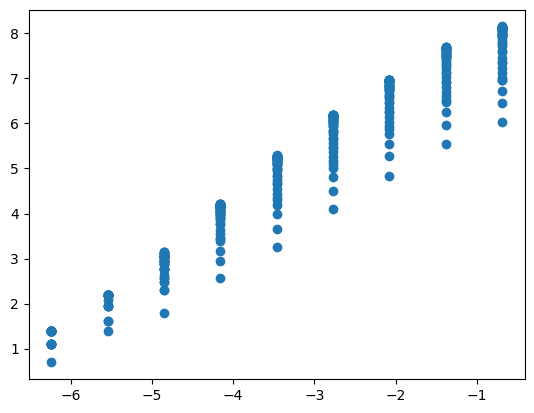

In [47]:
# Grafiicar  boxesboxes_matriz_transpuesta_reshape vs. matriz_log_counts_y_transpuesta_reshape

plt.scatter(boxesboxes_matriz_transpuesta_reshape, matriz_log_counts_y_transpuesta_reshape)

## Dim fractal final- Mamografia

la dimensi√≥n fractal de la mamografia es: 1.2137934877094068
Slope: 1.2137934877094068
Intercept: 8.945994975626707
R-squared: 0.9605898555272738
P-value: 4.194909268015036e-285
Standard error: 0.012246931691359398


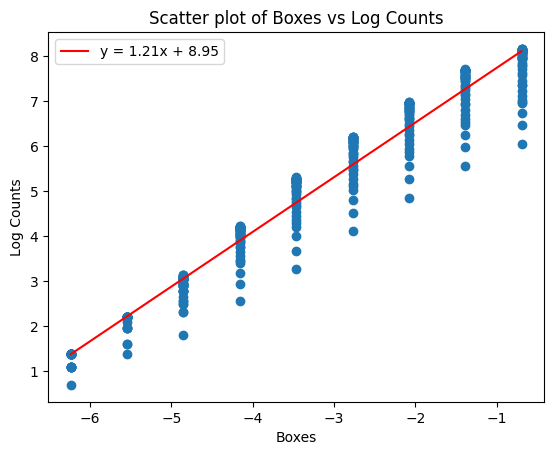

In [48]:

# Asegurarse de que las matrices est√°n en la forma correcta
boxesboxes_matriz_transpuesta_reshape = boxesboxes_matriz_transpuesta_reshape.reshape(-1)
matriz_log_counts_y_transpuesta_reshape = matriz_log_counts_y_transpuesta_reshape.reshape(-1)

# Verificar que ambas matrices tienen el mismo tama√±o
assert boxesboxes_matriz_transpuesta_reshape.shape == matriz_log_counts_y_transpuesta_reshape.shape, "Las matrices deben tener el mismo tama√±o"

# Graficar scatter plot
plt.scatter(boxesboxes_matriz_transpuesta_reshape, matriz_log_counts_y_transpuesta_reshape)
plt.xlabel('Boxes')
plt.ylabel('Log Counts')
plt.title('Scatter plot of Boxes vs Log Counts')

# Calcular la regresi√≥n lineal
slope, intercept, r_value, p_value, std_err = linregress(boxesboxes_matriz_transpuesta_reshape, matriz_log_counts_y_transpuesta_reshape)
print("la dimensi√≥n fractal de la mamografia es:",slope)
# Imprimir los resultados de la regresi√≥n lineal
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)
print("P-value:", p_value)
print("Standard error:", std_err)

# Graficar la l√≠nea de regresi√≥n
x = np.linspace(min(boxesboxes_matriz_transpuesta_reshape), max(boxesboxes_matriz_transpuesta_reshape), 100)
y = slope * x + intercept
plt.plot(x, y, color='red', label=f'y = {slope:.2f}x + {intercept:.2f}')

plt.legend()
plt.show()
